In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
%matplotlib inline

In [2]:
# Initial some 'global parameters'
# Is there a better to do so?
isInit = True
[leftx, lefty, rightx, righty, left_fit, right_fit, M, invM, xm_per_pix, ym_per_pix] = \
            [None for i in range(10)]

In [3]:
# utils
def plot2images(img1, img2, title1=None, title2=None):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 15))
    ax1.set_title(title1, fontsize=25)
    if len(img1.shape) == 3:
        ax1.imshow(img1)
    else:
        ax1.imshow(img1, cmap='gray')
    ax2.set_title(title2, fontsize=25)
    if len(img2.shape) == 3:
        ax2.imshow(img2)
    else:
        ax2.imshow(img2, cmap='gray')
        
def addText(img, lc, rc, co):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Left curv: '+str(lc)[:6]+' Right curv: '+ \
                str(rc)[:6], (90,80), font, 1.5,(255,255,255),3,cv2.LINE_AA)
    
    cv2.putText(img, 'Vehicle is ' + str(co)[:4] + ' meter left of center', (90,150), \
                font, 1.5,(255,255,255),3,cv2.LINE_AA)

## Camera Calibration
### Aim
Get the `mxt` and `dist` for undistortion later.

### Steps
* Setup `objpoints` (same for all images)
* Find `imgpoints` (corners found by `cv2.findChessboardCorners()`)
* Use `cv2.calibrateCamera()` get the `mxt` and `dist`


In [4]:
cal_path = './camera_cal/'

def cam_cal(cal_path, nx, ny):
    files = glob.glob(cal_path + '*')
    
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints, imgpoints = [], []

    for file in files:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny))

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return mtx, dist

### Check What I Get in `Camera Calibration`

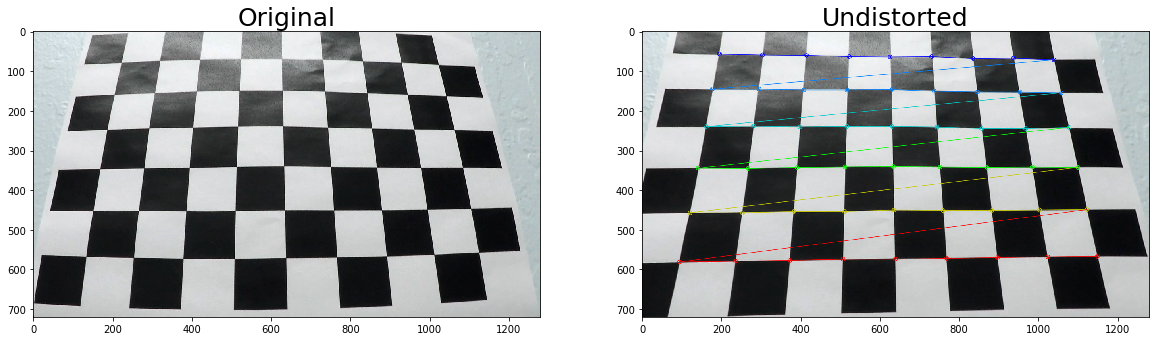

In [5]:
nx, ny = 9, 6
mtx, dist = cam_cal(cal_path, nx, ny)
img = cv2.imread('camera_cal/calibration3.jpg')
undst = cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(undst, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny))

if ret == True:
    undst = cv2.drawChessboardCorners(undst, (nx, ny), corners, ret)
    plot2images(img, undst, 'Original', 'Undistorted')

## Thresholding
### Aim
Combine thresholdings to build a binary image.

### Steps
* `Color threshold` (L and S)
* `Gradient threshold`
    * Sobelx
    * Direction
    * Magnitude
* Fuse these two thresholdings with `or`

In [6]:
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=150):
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # sobelx and sobely
    if orient == 'x':
        sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    else:
        sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    # scale to 8bit
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))

    # create a mask
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & ((scaled_sobel <= thresh_max)) ] = 1
    
    return binary_output


def mag_thresh(img, sobel_kernel=5, mag_thresh=(50, 150)):
    
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # sobelx and sobely
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    magSobel = np.sqrt(np.power(sobelX, 2) + np.power(sobelY, 2))
    
    # scale to 8bit
    scaled_sobel = np.uint8(255 * magSobel / np.max(magSobel))

    # create a mask
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & ((scaled_sobel <= mag_thresh[1])) ] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # sobelx and sobely
    sobelX = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    sobelY = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))

    arctan = np.arctan2(sobelY, sobelX)

    # create a mask
    binary_output = np.zeros_like(arctan)
    binary_output[(arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    return binary_output


In [7]:
def grad_thresh(img):
    # Read in an image
    mag = mag_thresh(img)
    dir = dir_threshold(img)
    absX = abs_sobel_thresh(img, orient='x')
    absY = abs_sobel_thresh(img, orient='y')

    binary_output = np.zeros_like(mag)
    # With no absY condition to get more nonzeros and augment the binary image
    # & (absY==1)
    binary_output[(mag==1) & (dir==1) |(absX==1)] = 1.0

    return binary_output

def color_thresh(img, err_thresh=200000):
    # Combined L and S channels
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)/255
    threshold1 = 0.55
#     threshold1 = 1
    sat = hls[:,:,2]
    sat_binary = sat > threshold1
    
    lightness = hls[:,:,1]
    threshold2 = 0.47
#     threshold2 = 1
    lit_binary = lightness > threshold2

    combined = np.logical_or(sat_binary, lit_binary)
    
    # If L channel ruins the information then not combine it (Only S channel instead)
    if combined[combined==True].shape[0] < err_thresh:
        out_img = combined + 0.0
    elif sat_binary[sat_binary==True].shape[0] < err_thresh:
        out_img = sat_binary + 0.0
    else:
        # If S channel is still not working, only use grad_thresh
        out_img = np.zeros_like(sat)
    
    return out_img

def fused_thresh(color, grad):
    return np.array(np.logical_or(color, grad) * 255, dtype=np.uint8)

## Check What I Get in `Thresholding`

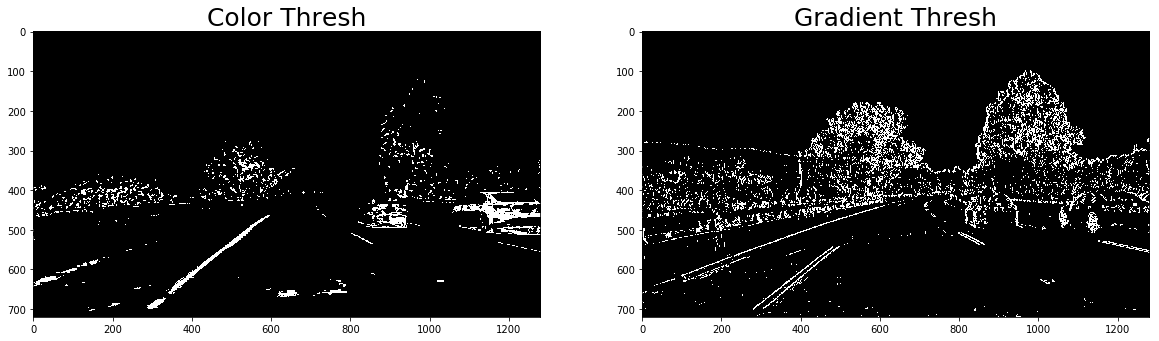

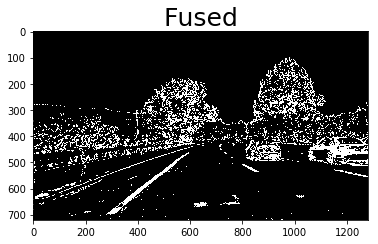

In [8]:
test_img = cv2.imread('test_images/test4.jpg')
undst = cv2.undistort(test_img, mtx, dist, None, mtx)
grad = grad_thresh(undst)
color = color_thresh(undst)

fused = fused_thresh(color, grad)
plot2images(color, grad, 'Color Thresh', 'Gradient Thresh')
plt.figure()
plt.title('Fused', fontsize=25)
plt.imshow(fused, cmap='gray')

## Warp
### Aim
Input an image and output its warped perspective form (birds-eye view).

### Steps
* Undistort the input using `mxt` and `dist` got in previous step
* Specify an area like masking
* Warp the area into **birds-eye view**

In [9]:
def get_warp_M(width=1280, height=720):
    src = np.array([[585, 455],[696, 455],[240, 680],[1060, 680]], dtype=np.float32)

    offset = 300
    dest = np.array([[offset, 0], [width-offset, 0], [offset, height], [width-offset, height]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(src, dest)
#     invM = np.linalg.inv(M)
    invM = cv2.getPerspectiveTransform(dest, src)
    return M, invM

def Warp(img, M):
    height, width = img.shape
    warped = cv2.warpPerspective(img, M, (width, height))

    return warped

def Unwarp(img, invM):
    height, width = img.shape[0], img.shape[1], 
    unwarped = cv2.warpPerspective(img, invM, (width, height))
    return unwarped

### Check What I Get in `Warp`

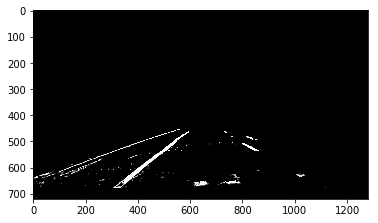

In [10]:
M, invM = get_warp_M()
warped= Warp(fused, M)
unwarped = Unwarp(warped, invM)
plt.imshow(unwarped, cmap='gray')

## Sliding Windows
### Aim
Find lane lines through `Sliding windows` for initialization.

### Steps
* Find points in windows
* Calculate the mean of x-axis each window as the center
* Draw windows and color the points

In [11]:
# Input: Binary Image
# Output: Windows Drew Image
def slide_windows(img):
    out_img = np.dstack((img, img, img))

    height, width = img.shape
    mid_point = width // 2

    margin = 80

    nWin = 9
    winLen = np.int(height // nWin)
    minPix = 60

    lBase, rBase = np.argmax(np.sum(img[:,:mid_point], axis=0)), \
            mid_point + np.argmax(np.sum(img[:,mid_point:], axis=0))

    lCur, rCur = lBase, rBase

    nonzerox = np.nonzero(img)[1]
    nonzeroy = np.nonzero(img)[0]

    # store all the points within windows
    left_lane_inds = []
    right_lane_inds = []

    for i in range(nWin):
        # from bottom to top of a image
        y_high = height - i * winLen
        y_low = y_high - winLen

        xleft_low = lCur - margin
        xleft_high = lCur + margin
        xright_low = rCur - margin
        xright_high = rCur + margin

        good_left_inds = ((nonzeroy >= y_low) & (nonzeroy <= y_high) & \
                          (nonzerox >= xleft_low) & (nonzerox <= xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= y_low) & (nonzeroy <= y_high) & \
                           (nonzerox >= xright_low) & (nonzerox <= xright_high)).nonzero()[0]
        
        if nonzerox[good_left_inds].shape[0] < minPix:
            pass
        else:
            left_lane_inds.append(good_left_inds)
            lWinMean = np.int(np.mean(nonzerox[good_left_inds]))
            xleft_low = lWinMean - margin
            xleft_high = lWinMean + margin
            cv2.rectangle(out_img,(xleft_low, y_low),\
                (xleft_high, y_high),(0, 255, 0), 2)
            lCur = lWinMean

        if nonzerox[good_right_inds].shape[0] < minPix:
            pass
        else:
            right_lane_inds.append(good_right_inds)
            rWinMean = np.int(np.mean(nonzerox[good_right_inds]))
            xright_low = rWinMean - margin
            xright_high = rWinMean + margin
            cv2.rectangle(out_img,(xright_low, y_low),\
                (xright_high, y_high),(0, 255, 0), 2)
            rCur = rWinMean
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, leftx, lefty, rightx, righty


## Check What I Get in Sliding Windows

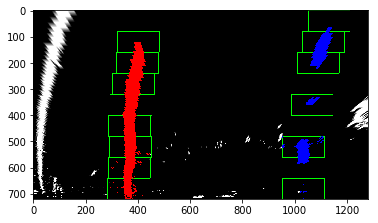

In [12]:
img, leftx, lefty, rightx, righty = slide_windows(warped)
plt.imshow(img)

## Polynomial
### Aim
Fit the points with a second polynomial and use the polynomial to replace the sliding windows.

### Steps
* Fit `polynomial`
* Find the points in the virtual windows

In [13]:
# Input: Binary Image
# Output: Windows Drew Image

def polynomial_find_lanes(img, leftx, lefty, rightx, righty):
    out_img = np.dstack((img, img, img))
    window_img = np.zeros_like(out_img)
    window_img_yellow = np.zeros_like(out_img)
    img_shape = out_img.shape

    margin = 80

    # Polynomial fitting
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Find points within the margin
    nonzerox = np.nonzero(img)[1]
    nonzeroy = np.nonzero(img)[0]

    xleft_center = left_fit[0] * nonzeroy ** 2 + left_fit[1] * nonzeroy + left_fit[2]
    xright_center = right_fit[0] * nonzeroy ** 2 + right_fit[1] * nonzeroy + right_fit[2]

    left_lane_inds = ((nonzerox >= xleft_center - margin) & (nonzerox <= xleft_center + margin)).nonzero()[0]
    right_lane_inds = ((nonzerox >= xright_center - margin) & (nonzerox <= xright_center + margin)).nonzero()[0]

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Visualize the right pts
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Visualize the polynomial lines
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    left_pts = np.array([np.stack((left_fitx, ploty),axis=1)], dtype=np.int32)
    right_pts = np.array([np.stack((right_fitx, ploty),axis=1)], dtype=np.int32)
    

    # Visualize the detection area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    
    cv2.polylines(window_img_yellow, left_pts, False, (0, 255, 255), thickness=5) 
    cv2.polylines(window_img_yellow, right_pts, False, (0, 255, 255), thickness=5) 
    
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    out_img = cv2.addWeighted(out_img, 1, window_img_yellow, 1, 0)
    return out_img, leftx, lefty, rightx, righty, left_fit, right_fit

## Check What I Get in Polynomial

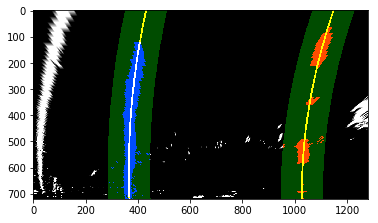

In [14]:
img, leftx, lefty, rightx, righty, left_fit, right_fit = polynomial_find_lanes(warped, leftx, lefty, rightx, righty)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Measuring Curvature
### Aim
Measuring curvature through the polynomial function

### Steps
* Turn pixels into real world meters
* Fit a meter-based polynomial
* Measure the curvature

In [15]:
def draw_lines_basic(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def get_realworld_scalar():
    img = cv2.imread('./test_images/straight_lines1.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = img.shape[0], img.shape[1]
    mid = np.int(width // 2)
    
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.Canny(img, 140, 270)
    lines = cv2.HoughLinesP(img, rho=1, theta=np.pi/180, \
                    threshold=9, minLineLength=3, maxLineGap=8)
    draw_lines_basic(img, lines)
    img = Warp(img, M)
    thres = 180
    img[img>thres] = 255
    img[img<=thres] = 0
    
    nonzerox = np.nonzero(img)[1]
    nonzeroy = np.nonzero(img)[0]
    
    dashed_lane = nonzeroy[(nonzerox >= mid) & (nonzeroy >= 360) & (nonzeroy <= 540)]
    y_low = np.min(dashed_lane)
    y_high = np.max(dashed_lane)
    
    left_offset = 250
    right_offset = 900
    
    left_sub_img = img[height-50:height, left_offset:400]
    right_sub_img = img[height-50:height, right_offset:1000]
    
    left_mean = np.mean(left_sub_img, axis=0)
    right_mean = np.mean(right_sub_img, axis=0)

    plt.plot(left_mean, 'darkorange')
    plt.plot(right_mean, 'dodgerblue')
    plt.show()
    
    x_low = np.argmax(left_mean[70:]) + left_offset + 70
    x_high = np.argmax(right_mean[:70]) + right_offset
    
    y_offset = 20
    print(x_high-x_low, y_high-y_low)
    
    return 3.7/(x_high-x_low), 3/(y_high-y_low-y_offset)

In [16]:
def measure_curvature(img, leftx, lefty, rightx, righty):
    global xm_per_pix, ym_per_pix
    img_shape = img.shape
    # Define conversions in x and y from pixels space to meters
    if xm_per_pix is None:
        xm_per_pix, ym_per_pix = get_realworld_scalar()

    y_eval = (img.shape[0] - 1) * ym_per_pix

    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    left_curverad = (1 + (2 * left_fit_cr[0] * y_eval + left_fit_cr[1]) ** 2 ) ** (3/2) / np.abs(2 * left_fit_cr[0])
    right_curverad = (1 + (2 * right_fit_cr[0] * y_eval + right_fit_cr[1]) ** 2 ) ** (3/2) / np.abs(2 * right_fit_cr[0])

    return left_curverad, right_curverad

def measure_car_offset(height, width, left_fit, right_fit):
    y_eval = height - 10
    x_mid = np.int(width / 2)
    
    left_x = (left_fit[0] * y_eval ** 2 + left_fit[1] * y_eval + left_fit[2]).astype(np.int32)
    right_x = (right_fit[0] * y_eval ** 2 + right_fit[1] * y_eval + right_fit[2]).astype(np.int32)

    img_mid = np.int((left_x + right_x) / 2)
    
    return xm_per_pix * (img_mid - x_mid)


## Check What I Get in Measuring Curvature

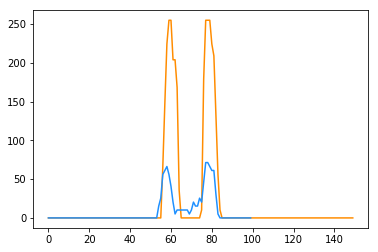

631 104
(628.7991448004016, 509.42139107050355)


In [17]:
print(measure_curvature(warped, leftx, lefty, rightx, righty))

## Pipeline
### Aim
Visualize curvature and lane lines

### Steps
* Inputing
* Undistortion
* Thresholding
* Warping
* Detection
    * Sliding Windows
    * Polylines
* Measuring curvature
* Unwarping detected lane lines
* Adding curvature to the image

In [18]:
def pipeline(img):
    global isInit, leftx, lefty, rightx, righty, left_fit, right_fit, M, invM
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    undst = cv2.undistort(img, mtx, dist, None, mtx)

    # Thresholding
    grad = grad_thresh(undst)
    color = color_thresh(undst)
    fused = fused_thresh(color, grad)
    height, width = fused.shape[0], fused.shape[1]
    # Warping
    if M is None:
        M, invM = get_warp_M()
    warped = Warp(fused, M)
    
    if isInit:
        isInit = False
        # Detection - Sliding Windows
        sw_img, leftx, lefty, rightx, righty = slide_windows(warped)

    # Detection - Polylines
    poly_img, leftx, lefty, rightx, righty, left_fit, right_fit = \
                polynomial_find_lanes(warped, leftx, lefty, rightx, righty)
    
    car_offset = measure_car_offset(height, width, left_fit, right_fit)
    
    # Measure curvature
    left_curv, right_curv = measure_curvature(warped, leftx, lefty, rightx, righty)

    # Visualize the polynomial lines
    out_img = np.dstack((warped, warped, warped))
    img_shape = warped.shape
    window_img = np.zeros_like(out_img)

    ploty = np.linspace(0, img_shape[0]-1, img_shape[0]).astype(np.int32)

    left_fitx = (left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]).astype(np.int32)
    right_fitx = (right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]).astype(np.int32)

    # Visualize the Lane lines and Area between them
    line_left_margin = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    line_right_margin = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    area_pts = np.hstack((line_left_margin, line_right_margin))
    cv2.fillPoly(window_img, np.int_([area_pts]), (0, 255, 0))

    left_pts = np.array([np.stack((left_fitx, ploty),axis=1)], dtype=np.int32)
    right_pts = np.array([np.stack((right_fitx, ploty),axis=1)], dtype=np.int32)

    cv2.polylines(window_img, left_pts, False, (0, 255, 255), thickness=10) 
    cv2.polylines(window_img, right_pts, False, (0, 255, 255), thickness=10) 

    window_img = Unwarp(window_img, invM)
    out_img = cv2.addWeighted(undst, 1, window_img, 0.4, 0)

    return out_img, left_curv, right_curv, car_offset

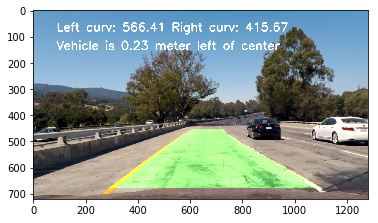

In [ ]:
isInit = True
img = cv2.imread('test_images/test1.jpg')
img, lc, rc, co = pipeline(img)
addText(img,lc,rc, co)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
import glob
files = glob.glob('./test_images/*')
for file in files:
    img = cv2.imread(file)
    isInit=True
    result = pipeline(img)[0]
    cv2.imwrite('output_images/' + file.split('/')[-1], result)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
        
def process_image(image):
    img, lc, rc, co  = pipeline(image)
    addText(img, lc, rc, co)
    return img

isInit = True 
white_output = 'test_videos_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output.mp4
[MoviePy] Writing video test_videos_output.mp4


 96%|█████████▋| 1214/1261 [04:25<00:10,  4.63it/s]